# Week 5 Exercise

Choose at least **one** of the task below as practice.

---
## Task 1: Computer monitor

We have implemented the CPU monitor in the lecture.
- try to add more functions to its and make it display more information.
  - For example: memory usage, disk usage, internet connection etc.
- try to use more complex pipeline to display a variety of information.
  - For example: CPU usage of past 10s/30s/1min,  


In [ ]:
!pip install rx --quiet

### Define and initialize observables

In [ ]:
import psutil
from rx import interval
from rx.operators import map, publish, take, buffer_with_count
import time

sys_data = interval(0.1).pipe(
  map(lambda x: 
                {'cpu_pct':psutil.cpu_percent(), 
                 'virtual_memory_pct':psutil.virtual_memory()[2], 
                 'swap_memory_pct':psutil.swap_memory()[3], 
                 'disk_usage_pct':psutil.disk_usage('/')[3],
                 'net_speed':psutil.net_if_stats()['eth0'][2],
                 }
      ),
  publish(),
)
sys_data.connect() # Start producing data

take(4)(sys_data).subscribe(print)
time.sleep(0.5)

{'cpu_pct': 54.7, 'virtual_memory_pct': 7.0, 'swap_memory_pct': 0, 'disk_usage_pct': 34.3, 'net_speed': 10000}
{'cpu_pct': 73.7, 'virtual_memory_pct': 7.0, 'swap_memory_pct': 0, 'disk_usage_pct': 34.3, 'net_speed': 10000}
{'cpu_pct': 90.5, 'virtual_memory_pct': 7.0, 'swap_memory_pct': 0, 'disk_usage_pct': 34.3, 'net_speed': 10000}
{'cpu_pct': 47.6, 'virtual_memory_pct': 6.2, 'swap_memory_pct': 0, 'disk_usage_pct': 34.3, 'net_speed': 10000}


### Define the monitor function/Class

In [ ]:
%matplotlib inline
import numpy as np
import pylab as plt
from IPython import display

class SysMonitor(object):

  def __init__(self, sys_data, npoints):
    self.sys_data = sys_data
    self.npoints = npoints
    self.sys_data_window = self.sys_data.pipe(
      buffer_with_count(self.npoints, 1)
    )
    # self.high_usage = self.cpu_data.pipe(
    #   buffer_with_count(4, 1),
    #   map(lambda readings: all(r > 20 for r in readings)),
    # )

  def start(self, util='cpu_pct', duration=5):
    self.init_plot()
    # self.high_cpu.subscribe(self.update_warning)
    self.sys_data_window.subscribe(lambda x: self.update_plot(x, util))
    time.sleep(duration)

  def init_plot(self):
    (lines,) = plt.plot([], [])
    plt.xlim(0, self.npoints)
    plt.ylim(0, 120)
    self.lines = lines
    # self.label = plt.text(1, 1, "normal")
    display.display(plt.gcf())

  def update_plot(self, sys_readings, util='cpu_pct'):
    self.lines.set_xdata(np.arange(len(sys_readings)))
    self.lines.set_ydata(np.array([sys_reading[util] for sys_reading in sys_readings]))
    display.clear_output(wait=True)
    display.display(plt.gcf())

  # def update_warning(self, is_high):
  #   if is_high:
  #     self.label.set_text("high")
  #   else:
  #     self.label.set_text("normal")


In [ ]:
monitor = SysMonitor(sys_data, 10)

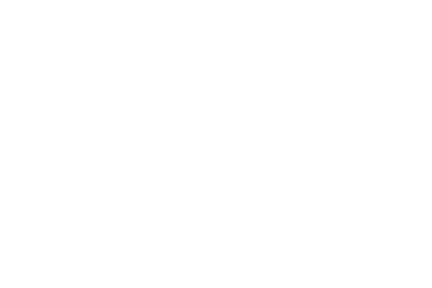

In [ ]:
monitor.start(util='cpu_pct')

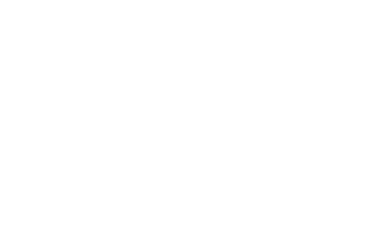

In [ ]:
monitor.start(util='virtual_memory_pct')

---

## Task 2: Calculate integration with Monte Carlo method

- Use Theano, TensorFlow to calculate the integration $∫_0^1 x^2$.
- Compare with the serial implementation.

### Serial implementation

In [ ]:
import numpy as np
INTERVAL = 0.0001
x_val = np.arange(0, 1, INTERVAL)
def integration_serial(x_val):
  integrand_sum = 0.0
  for x in x_val:
    integrand_sum += x**2
  return integrand_sum*INTERVAL

Calculate the time cost

In [ ]:
%%time
serial_res = integration_serial(x_val)
print(serial_res)

0.33328333499999835
CPU times: user 4.36 ms, sys: 1.07 ms, total: 5.43 ms
Wall time: 5.38 ms


### Use Theano 

In [ ]:
!pip install Theano --quiet

     |████████████████████████████████| 2.8 MB 4.2 MB/s 


In [ ]:
import theano.tensor as T
import theano as th

# enable OpenMP support
th.config.openmp_elemwise_minsize = 1000
th.config.openmp = True

# define theano function
x = T.vector("x")
integrand = INTERVAL * x ** 2
integral = integrand.sum()
calculate_intgeration = th.function([x], integral)

Calculate the time cost

In [ ]:
%%time
theano_res = calculate_intgeration(x_val)
print(theano_res)

0.33328333499999835
CPU times: user 255 µs, sys: 57 µs, total: 312 µs
Wall time: 277 µs


### Use TensorFlow

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
x = tf.placeholder("float64", name="x")

integrand = INTERVAL * x ** 2
integral = tf.reduce_sum(tf.cast(integrand, "float64"))

In [ ]:
tfsess = tf.Session()

Calculate the time cost

In [ ]:
%%time
tfsess.run(integral, {x:x_val})

CPU times: user 0 ns, sys: 1.86 ms, total: 1.86 ms
Wall time: 1.2 ms


0.33328333500000007